### Locus comparison plot for colocalization Analysis
Author: Lu and Jenny Empawi

### Required files
* SNP position which includes **chr**, **snpid**, **cm**, **pos**, **a1**, **a2**, **pos2**
* colocboost output (s3://statfungen/ftp_fgc_xqtl/analysis_result/ColocBoost/AD_xQTL/)

#### Load libraries

In [1]:
library(locuscomparer)
library(data.table)
library(dplyr)
library(tidyverse)
library(colocboost)
library(pecotmr)
library(MixtureMissing)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.2.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubri

#### Load SNP position

In [2]:
#snppos <- fread("/restricted/projectnb/xqtl/ROSMAP_WGS/plink/by_chr/ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc_6.bim", header=F) # path in BU cluster
snppos <- fread("/data/ROSMAP/genotype/analysis_ready/geno_by_chrom/ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc.6.bim", header=F) # path in cloud

colnames(snppos) <- c("chr", "snpid", "cm", "pos", "a1", "a2")
snppos$pos2 <- paste(paste0("chr",snppos$chr), snppos$pos, sep=":")
snppos$chr <- paste0("chr",snppos$chr)
snppos$snpid <- gsub("_", ":", snppos$snpid)
head(snppos)

chr,snpid,cm,pos,a1,a2,pos2
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr6,chr6:63841:T:C,0,63841,C,T,chr6:63841
chr6,chr6:63889:C:G,0,63889,G,C,chr6:63889
chr6,chr6:64182:A:C,0,64182,C,A,chr6:64182
chr6,chr6:64204:T:A,0,64204,A,T,chr6:64204
chr6,chr6:64241:C:G,0,64241,G,C,chr6:64241
chr6,chr6:64265:G:C,0,64265,C,G,chr6:64265


In [3]:
target_snps <- snppos[snppos$chr == "chr6" & 
                       snppos$pos >= 28267058 & 
                       snppos$pos <= 28278224, ]
# Display the results
if(nrow(target_snps) > 0) {
  print(target_snps[, c("snpid", "chr", "pos", "pos2")])
} else {
  print("No SNPs found in the specified region")
}

                             snpid    chr      pos          pos2
                            <char> <char>    <int>        <char>
  1:             chr6:28267096:G:A   chr6 28267096 chr6:28267096
  2: chr6:28267126:AAGCGCTCCGAAG:A   chr6 28267126 chr6:28267126
  3:            chr6:28267165:CT:C   chr6 28267165 chr6:28267165
  4:             chr6:28267170:A:G   chr6 28267170 chr6:28267170
  5:             chr6:28267225:C:T   chr6 28267225 chr6:28267225
 ---                                                            
243:             chr6:28278009:G:C   chr6 28278009 chr6:28278009
244:            chr6:28278054:TC:T   chr6 28278054 chr6:28278054
245:             chr6:28278148:T:A   chr6 28278148 chr6:28278148
246:             chr6:28278193:G:T   chr6 28278193 chr6:28278193
247:             chr6:28278210:G:T   chr6 28278210 chr6:28278210


#### Calculate LD

In [4]:
calculate_LD <- function(genotype_basepath, variant_list){
    
    variant_list <- data.frame(variant_ID = variant_list) %>%
      separate(variant_ID, into = c("chr", "pos", "a1", "a2"), sep = ":", remove = FALSE) %>%
      mutate(pos = as.numeric(pos),
             chr = as.numeric(str_remove(chr, "chr")))
    pos <- variant_list$pos
    CHR <- variant_list$chr[1]
    region <- paste0("chr", CHR, ":", min(pos)-1, "-", max(pos)+1)
    genotype_path <- paste0(genotype_basepath, CHR)
    genotype <- load_genotype_region(genotype_path, region = region)
    colnames(genotype) <- gsub("_", ":", colnames(genotype))

    overlapped_variants <- intersect(variant_list$variant_ID, colnames(genotype))
    if (length(overlapped_variants) != length(variant_list$variant_ID)){
        missing_variants <- setdiff(variant_list$variant_ID, overlapped_variants)
        message("There are ", length(missing_variants), " variants in 'variant_list', but missing in genotype data.\n",
                "Please check variant_ID of these variants: ", paste0(missing_variants, collapse = ";"), "!")
    }
    geno <- genotype[, overlapped_variants]
    geno <- mean_impute(geno)
    get_cormat(geno)
    
}

In [5]:
variant_list <- c("chr6:28267170:A:G", "chr6:28267225:C:T")
#genotype_basepath <- "/restricted/projectnb/xqtl/ROSMAP_WGS/plink/by_chr/ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc_" # path in BU cluster
genotype_basepath <- "/data/ROSMAP/genotype/analysis_ready/geno_by_chrom/ROSMAP_NIA_WGS.leftnorm.bcftools_qc.plink_qc_" # path in cloud
ld <- calculate_LD(genotype_basepath, variant_list)
ld

,chr6:28267170:A:G,chr6:28267225:C:T
chr6:28267170:A:G,1.0000000000,-0.0008680556
chr6:28267225:C:T,-0.0008680556,1.0000000000


In [6]:
# change ld matrix format
ld_long <- melt(ld, id.vars = "SNP", 
                variable.name = "SNP_B", 
                value.name = "R2")

# Rename columns
colnames(ld_long) <- c("SNP_A", "SNP_B", "R2")

# Extract chromosome and position - handle the full SNP format
ld_long$CHR_A <- sapply(strsplit(as.character(ld_long$SNP_A), ":"), function(x) x[1])
ld_long$BP_A <- as.numeric(sapply(strsplit(as.character(ld_long$SNP_A), ":"), function(x) x[2]))
ld_long$CHR_B <- sapply(strsplit(as.character(ld_long$SNP_B), ":"), function(x) x[1])
ld_long$BP_B <- as.numeric(sapply(strsplit(as.character(ld_long$SNP_B), ":"), function(x) x[2]))

# Reorder columns
ld_final <- ld_long[, c("CHR_A", "BP_A", "SNP_A", "CHR_B", "BP_B", "SNP_B", "R2")]

# Remove self-correlations
ld_final <- ld_final[!(ld_long$SNP_A == ld_long$SNP_B & ld_long$R2 == 1), ]

print(ld_final)

  CHR_A     BP_A             SNP_A CHR_B     BP_B             SNP_B
1  chr6 28267170 chr6:28267170:A:G  chr6 28267170 chr6:28267170:A:G
2  chr6 28267225 chr6:28267225:C:T  chr6 28267170 chr6:28267170:A:G
3  chr6 28267170 chr6:28267170:A:G  chr6 28267225 chr6:28267225:C:T
4  chr6 28267225 chr6:28267225:C:T  chr6 28267225 chr6:28267225:C:T
             R2
1  1.0000000000
2 -0.0008680556
3 -0.0008680556
4  1.0000000000


#### Load colocboost file

In [7]:
#cb_res = readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/locuszoom/AD_xQTL.chr6_ENSG00000197062.cb_xqtl_AD_Wightman_Excluding23andMe_2021.rds")[[1]]  # path in BU cluster
cb_res = readRDS("/data/analysis_result/ColocBoost/AD_xQTL/ROSMAP/AD_xQTL.chr6_ENSG00000197062.cb_xqtl_AD_Wightman_Excluding23andMe_2021.rds")[[1]]  # path in cloud

#cb_res %>% str
#cb_res$cos_summary
pv = lapply(cb_res$data_info$z, function(zz) pchisq(zz, 1, lower.tail = F))
names(pv) = cb_res$data_info$outcome_info$outcome_names

# Extract middle string for all except AD_Wightman
simple_names <- sapply(names(pv), function(name) {
  if(grepl("AD_Wightman", name)) {
    name  # Keep AD_Wightman_Excluding23andMe_2021 unchanged
  } else {
    # Split by underscore and take the middle part
    parts <- strsplit(name, "_")[[1]]
    parts[2]  # This is the celltype (middle part)
  }
})
names(pv) <- simple_names
names(pv)

[1] "Ast"                               "Exc"                              
 [3] "Inh"                               "OPC"                              
 [5] "Oli"                               "AC"                               
 [7] "DLPFC"                             "Monocyte"                         
 [9] "PCC"                               "AD_Wightman_Excluding23andMe_2021"

#### Prepare data and get lead SNP

In [8]:
gene = "ENSG00000197062"   # insert your gene of interest
chr =  "6" # insert the chr
celltype = "Ast"   # insert the celltype

In [9]:
# Get SNP names from variables
snp_ids <- cb_res$data_info$variables

# For eQTL data
eqtl_snp <- data.frame(pv = pv[[celltype]])
eqtl_snp$logp = -log10(eqtl_snp$pv)
eqtl_snp$rsid = snp_ids  # Use actual SNP IDs from variables
use.eqtl_snp = eqtl_snp[, c("rsid", "pv", "logp")]
colnames(use.eqtl_snp) = c("rsid", "pval", "logp")

# For GWAS data
gwas_snp <- data.frame(pv = pv[["AD_Wightman_Excluding23andMe_2021"]])
gwas_snp$logp = -log10(gwas_snp$pv)
gwas_snp$rsid = snp_ids  # Use same SNP IDs
use.gwas_snp = gwas_snp[, c("rsid", "pv", "logp")]
colnames(use.gwas_snp) = c("rsid", "pval", "logp")

tmp = merge(use.eqtl_snp, use.gwas_snp, by="rsid")
colnames(tmp) = c("rsid", "pval1", "logp1", "pval2", "logp2")
merged = merge(tmp, snppos, by.x="rsid", by.y="snpid")

use.eqtl_snp = merge(use.eqtl_snp, snppos, by.x="rsid", by.y="snpid")
use.gwas_snp = merge(use.gwas_snp, snppos, by.x="rsid", by.y="snpid")

get_lead_snp = function(merged, snp = NULL){
  if (is.null(snp)) {
    snp = merged[which.min(merged$pval1 + merged$pval2), 'rsid']
  }
  else {
    if (!snp %in% merged$rsid) {
      stop(sprintf("%s not found in the intersection of in_fn1 and in_fn2.", snp))
    }
  }
  return(as.character(snp))
}

# Get lead SNP
snp = get_lead_snp(merged)
cat("Lead SNP:", snp, "\n")

Lead SNP: chr6:30382705:C:T 


In [10]:
# assign color
color = assign_color(merged$rsid, snp, ld_final)

# add label
add_label = function(merged, snp){
  merged$label = ifelse(merged$rsid %in% snp, merged$rsid, '')
  return(merged)
}

In [11]:
# Rename the columns to what the plotting functions expect
colnames(merged)[colnames(merged) == "pval.x"] <- "pval1"
colnames(merged)[colnames(merged) == "logp.x"] <- "logp1"
colnames(merged)[colnames(merged) == "pval.y"] <- "pval2"
colnames(merged)[colnames(merged) == "logp.y"] <- "logp2"

# Also update use.eqtl_snp and use.gwas_snp if needed
colnames(use.eqtl_snp)[colnames(use.eqtl_snp) == "pval"] <- "pval1"
colnames(use.eqtl_snp)[colnames(use.eqtl_snp) == "logp"] <- "logp1"

colnames(use.gwas_snp)[colnames(use.gwas_snp) == "pval"] <- "pval2" 
colnames(use.gwas_snp)[colnames(use.gwas_snp) == "logp"] <- "logp2"

# Now continue with your analysis
color = assign_color(merged$rsid, snp, ld_final)
merged = add_label(merged, snp)

# Plotting
shape = ifelse(merged$rsid == snp, 23, 21)
names(shape) = merged$rsid
size = ifelse(merged$rsid == snp, 3, 2)
names(size) = merged$rsid

#### Scatterplot

In [12]:
#make_scatterplot(merged, title1 = 'eQTL', title2 = 'GWAS', color, shape, size)

#### Locus zoom plot - eQTL SNP

In [13]:
colnames(use.eqtl_snp)[colnames(use.eqtl_snp) == "logp1"] <- "logp"
colnames(use.eqtl_snp)[colnames(use.eqtl_snp) == "pval1"] <- "pval"

chr = unique(use.eqtl_snp$chr)
use.eqtl_snp = add_label(use.eqtl_snp, snp)
color = assign_color(use.eqtl_snp$rsid, snp, ld_final)
#make_locuszoom(use.eqtl_snp, title = 'eQTL', chr, color, shape, size)

#### Locus zoom plot - GWAS SNP

In [14]:
colnames(use.gwas_snp)[colnames(use.gwas_snp) == "logp2"] <- "logp"
colnames(use.gwas_snp)[colnames(use.gwas_snp) == "pval2"] <- "pval"

chr = unique(use.gwas_snp$chr)
use.gwas_snp = add_label(use.gwas_snp, snp)
color = assign_color(use.gwas_snp$rsid, snp, ld_final)
#make_locuszoom(use.gwas_snp, title = 'GWAS', chr, color, shape, size)

#### Combine plots

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


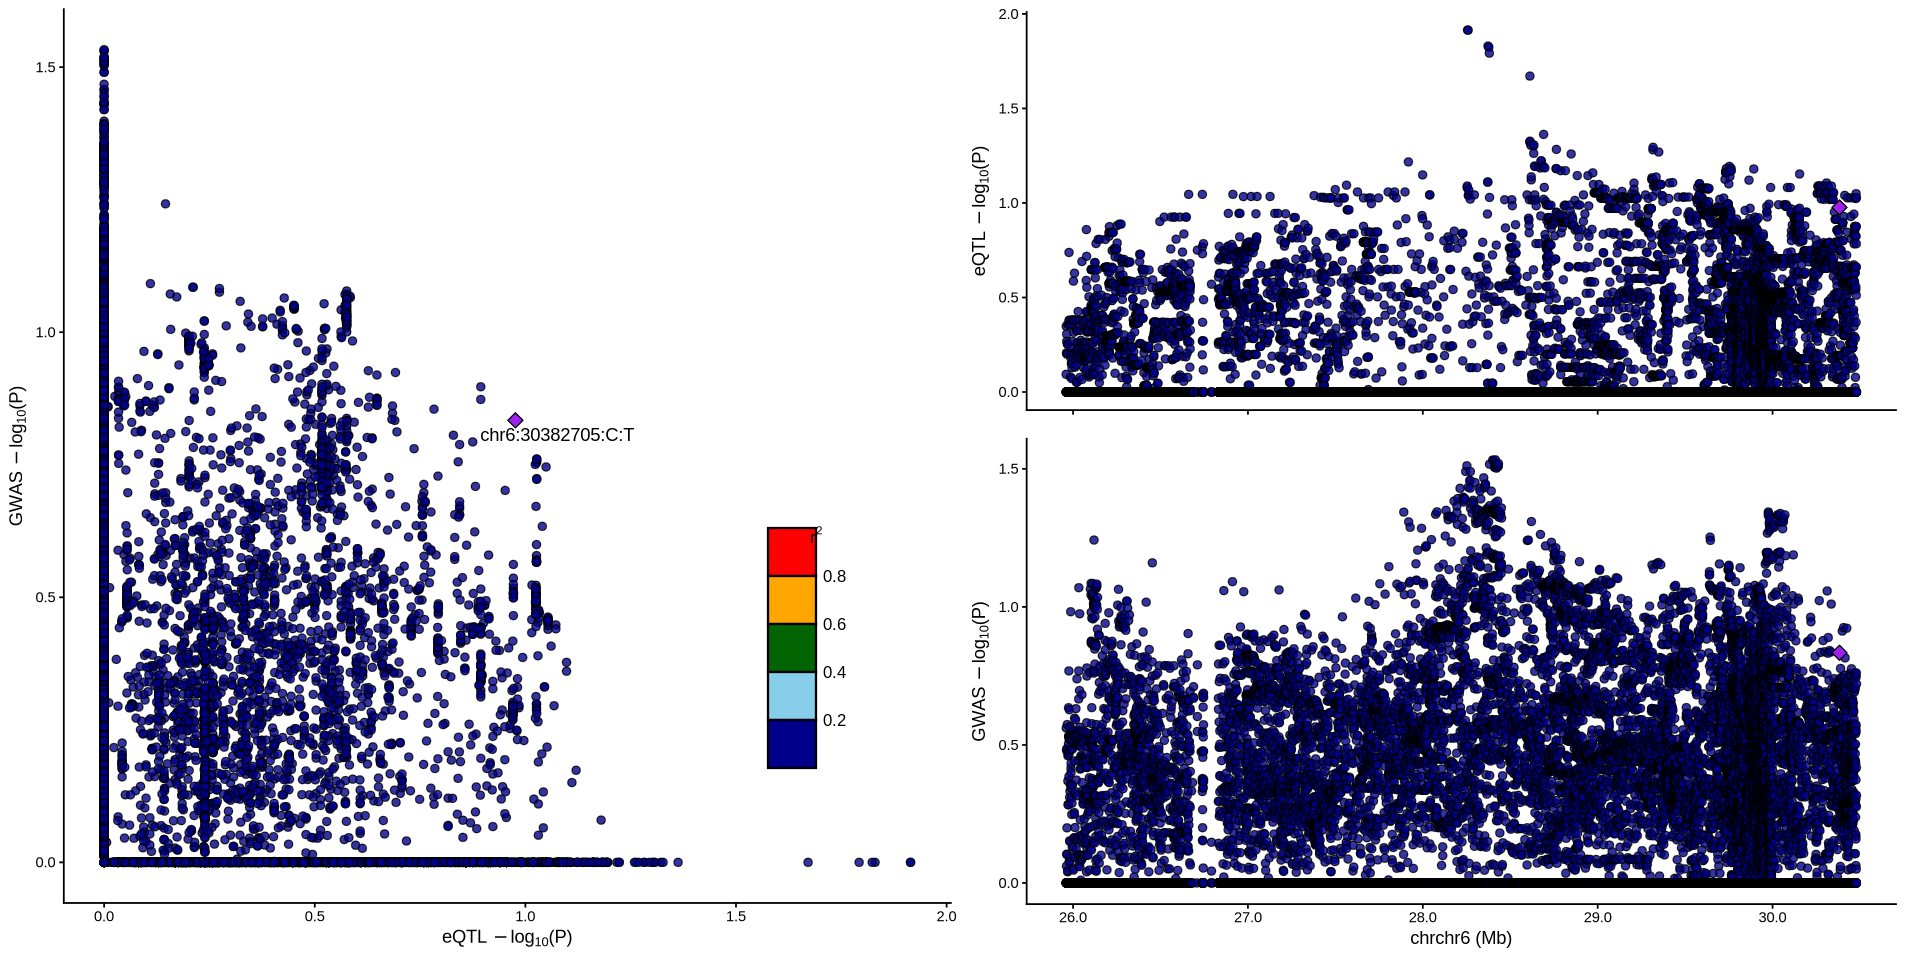

In [15]:
options(repr.plot.width = 16, repr.plot.height = 8)
p1 <- make_combined_plot(merged, 'eQTL', 'GWAS', ld_final, chr, snp)
p1
ggsave("ZSCAN26_case_example.png", p1, width = 12, height = 10, dpi = 300)